# 08 - Evaluation on Test-Shift with Threshold-Only Adaptation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/code_refactor/notebooks/08_evaluation_shifted_threshold_only.ipynb)

**Threshold-Only Adaptation**

This notebook implements an ablation study to isolate the contribution of **threshold recalibration** from full model adaptation.

**Experimental Setup:**
- Models: Trained on Clean data (NO retraining)
- Thresholds: RE-calibrated on Val-shift (F1-optimal)
- Test: Evaluated on Test-shift

**Goal:**
Measure how much performance can be recovered through threshold adaptation alone, without model retraining.

**Metrics computed:**
- Image-level: AUROC, AUPRC, F1, Accuracy, Precision, Recall
- Pixel-level: Pixel AUROC, PRO (Per-Region Overlap)

## 1. Setup & Configuration

In [1]:
from google.colab import drive
from pathlib import Path
import os
import sys

drive.mount('/content/drive')

repo_dir = '/content/Detection-of-Anomalies-with-Localization'

# Remove if exists
if os.path.exists(repo_dir):
    print("Removing existing repository...")
    !rm -rf {repo_dir}

# Clone from main branch
!git clone -b code_refactor https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git {repo_dir}

# Setup paths
PROJECT_ROOT = Path(repo_dir)

# Dataset location
DATASET_PATH = Path('/content/drive/MyDrive/mvtec_shifted')

# Output directories on Drive
DRIVE_ROOT = Path('/content/drive/MyDrive/anomaly_detection_project')
PATCHCORE_MODELS_DIR = DRIVE_ROOT / '04_patchcore_clean_outputs'
PADIM_MODELS_DIR = DRIVE_ROOT / '05_padim_clean_outputs'

RESULTS_DIR = PROJECT_ROOT / 'outputs' / 'results'
THRESHOLDS_DIR = PROJECT_ROOT / 'outputs' / 'thresholds'
VIZ_DIR = PROJECT_ROOT / 'outputs' / 'visualizations' / 'shift_threshold_only'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
THRESHOLDS_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Verify dataset exists
if not DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATASET_PATH}\n"
        f"Please ensure mvtec_shifted folder is in your Google Drive root."
    )

# Add project root to Python path
sys.path.insert(0, str(PROJECT_ROOT))

Mounted at /content/drive
Cloning into '/content/Detection-of-Anomalies-with-Localization'...
remote: Enumerating objects: 1393, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 1393 (delta 95), reused 164 (delta 57), pack-reused 1126 (from 3)
Receiving objects: 100% (1393/1393), 438.21 MiB | 20.53 MiB/s, done.
Resolving deltas: 100% (713/713), done.
Updating files: 100% (184/184), done.
Error downloading object: outputs/models/padim_carpet_clean.pt (c5f08e6): Smudge error: Error downloading outputs/models/padim_carpet_clean.pt (c5f08e6a66aaad9c354e37e3dfcdc363d0fc17764922d97746ee0ff947df2768): batch response: This repository exceeded its LFS budget. The account responsible for the budget should increase it to restore access.

Errors logged to /content/Detection-of-Anomalies-with-Localization/.git/lfs/logs/20260107T080456.42180932.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-pro

Install both `faiss` and `anomalib` libraries, required for running PatchCore and PaDiM models respectively. **Must be done before any imports.**

In [2]:
!pip install faiss-cpu --quiet
!pip install anomalib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 54.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 27.8 MB/s eta 0:00:00


Import necessary libraries and modules.

In [3]:
# Standard imports
import json
import warnings
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Project imports
from src.utils.reproducibility import set_seed
from src.utils.config import load_config
from src.utils.paths import ProjectPaths
from src.data.splitter import load_splits
from src.data.dataset import MVTecDataset
from src.data.transforms import get_clean_transforms
from src.models.patchcore import PatchCore
from src.models.padim_wrapper import PadimWrapper
from src.utils.utils import custom_collate_fn

# Metrics imports
from src.metrics import (
    calibrate_threshold,
    ThresholdCalibrator,
    compute_image_metrics,
    compute_pixel_metrics,
    compute_roc_curve,
    compute_pr_curve,
    compute_confusion_matrix,
    aggregate_metrics,
    aggregate_pixel_metrics
)

# Set random seed for reproducibility
set_seed(42)

# Load configuration
config = load_config(PROJECT_ROOT / 'configs' / 'experiment_config.yaml')
paths = ProjectPaths(PROJECT_ROOT)

# Classes to evaluate
CLASSES = config.dataset.classes  # ['hazelnut', 'carpet', 'zipper']

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {DEVICE}")

Loaded configuration from /content/Detection-of-Anomalies-with-Localization/configs/experiment_config.yaml
Using device: cpu


## 2. Load Shifted Data Splits

In [4]:
# Load shifted splits
SPLITS_PATH = paths.get_split_path('shifted')
splits = load_splits(SPLITS_PATH)

# Print split statistics
print("\nSplit Statistics:")
print("-" * 50)
for class_name in CLASSES:
    val_n = len(splits[class_name]['val']['images'])
    test_n = len(splits[class_name]['test']['images'])

    val_normal = sum(1 for l in splits[class_name]['val']['labels'] if l == 0)
    val_anom = sum(1 for l in splits[class_name]['val']['labels'] if l == 1)
    test_normal = sum(1 for l in splits[class_name]['test']['labels'] if l == 0)
    test_anom = sum(1 for l in splits[class_name]['test']['labels'] if l == 1)

    print(f"{class_name}:")
    print(f"  Val: {val_n} ({val_normal} normal, {val_anom} anomalous)")
    print(f"  Test: {test_n} ({test_normal} normal, {test_anom} anomalous)")


Split Statistics:
--------------------------------------------------
hazelnut:
  Val: 100 (79 normal, 21 anomalous)
  Test: 89 (40 normal, 49 anomalous)
carpet:
  Val: 82 (56 normal, 26 anomalous)
  Test: 91 (28 normal, 63 anomalous)
zipper:
  Val: 83 (48 normal, 35 anomalous)
  Test: 116 (32 normal, 84 anomalous)


## 3. Threshold Calibration on Val-Shift

**CRITICAL STEP:** We recalibrate thresholds using predictions from **clean-trained models** on **Val-shift** data.

This isolates the effect of threshold adaptation from model adaptation.

In [5]:
# Initialize threshold calibrators
patchcore_calibrator = ThresholdCalibrator('patchcore')
padim_calibrator = ThresholdCalibrator('padim')

# Get transforms
transform = get_clean_transforms(image_size=config.dataset.image_size)

# Store calibration data for visualization
calibration_data = {
    'patchcore': {},
    'padim': {}
}

### PatchCore: Calibrate thresholds on Val-shift

In [6]:
print("\n>>> PATCHCORE <<<\n")

for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # Create validation dataset
    val_split = splits[class_name]['val']
    val_dataset = MVTecDataset.from_split(
        val_split,
        transform=transform,
        phase='val'
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=0,
        collate_fn=custom_collate_fn
    )

    # Load model trained on CLEAN data
    model = PatchCore(
        backbone_layers=config.patchcore.layers,
        patch_size=config.patchcore.patch_size,
        coreset_ratio=config.patchcore.coreset_sampling_ratio,
        n_neighbors=config.patchcore.n_neighbors,
        device=DEVICE
    )
    model.load(PATCHCORE_MODELS_DIR, class_name, domain='clean')

    # Collect predictions on VAL-SHIFT
    val_scores = []
    val_labels = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(val_loader, desc=f'Validating {class_name}'):
            images = images.to(DEVICE)
            scores, _ = model.predict(images, return_heatmaps=False)

            val_scores.extend(scores.tolist())
            val_labels.extend(labels.numpy().tolist())

    # Convert to arrays
    val_scores = np.array(val_scores)
    val_labels = np.array(val_labels)

    # Calibrate threshold on Val-shift
    threshold = patchcore_calibrator.calibrate(class_name, val_scores, val_labels)
    print(f"  Calibrated threshold: {threshold:.4f}")

    # Store for visualization
    calibration_data['patchcore'][class_name] = {
        'scores': val_scores,
        'labels': val_labels,
        'threshold': threshold
    }

# Save calibrated thresholds
patchcore_calibrator.save(THRESHOLDS_DIR / 'shift_threshold_only_patchcore.json')
print(f"\n[OK] Thresholds saved: shift_threshold_only_patchcore.json")


>>> PATCHCORE <<<


--- HAZELNUT ---
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 62.3MB/s]


Validating hazelnut:   0%|          | 0/13 [00:00<?, ?it/s]

  Calibrated threshold: 593.5777

--- CARPET ---


Validating carpet:   0%|          | 0/11 [00:00<?, ?it/s]

  Calibrated threshold: 326.0456

--- ZIPPER ---


Validating zipper:   0%|          | 0/11 [00:00<?, ?it/s]

  Calibrated threshold: 405.8055
[OK] Thresholds saved: shift_threshold_only_patchcore.json

[OK] Thresholds saved: shift_threshold_only_patchcore.json


### PaDiM: Calibrate thresholds on Val-shift

In [7]:
print("\n>>> PADIM <<<\n")

for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # Create validation dataset
    val_split = splits[class_name]['val']
    val_dataset = MVTecDataset.from_split(
        val_split,
        transform=transform,
        phase='val'
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=0,
        collate_fn=custom_collate_fn
    )

    # Load model trained on CLEAN data
    model = PadimWrapper(
        backbone=config.padim.backbone,
        layers=config.padim.layers,
        n_features=config.padim.n_features,
        image_size=config.dataset.image_size,
        device=DEVICE
    )
    model.load(PADIM_MODELS_DIR / f'padim_{class_name}_clean.pt')

    # Collect predictions on VAL-SHIFT
    val_scores = []
    val_labels = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(val_loader, desc=f'Validating {class_name}'):
            images = images.to(DEVICE)
            scores, _ = model.predict(images, return_heatmaps=False)

            val_scores.extend(scores.tolist())
            val_labels.extend(labels.numpy().tolist())

    # Convert to arrays
    val_scores = np.array(val_scores)
    val_labels = np.array(val_labels)

    # Calibrate threshold on Val-shift
    threshold = padim_calibrator.calibrate(class_name, val_scores, val_labels)
    print(f"  Calibrated threshold: {threshold:.4f}")

    # Store for visualization
    calibration_data['padim'][class_name] = {
        'scores': val_scores,
        'labels': val_labels,
        'threshold': threshold
    }

# Save calibrated thresholds
padim_calibrator.save(THRESHOLDS_DIR / 'shift_threshold_only_padim.json')
print(f"\n[OK] Thresholds saved: shift_threshold_only_padim.json")


>>> PADIM <<<


--- HAZELNUT ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

[OK] Model loaded: padim_hazelnut_clean.pt


Validating hazelnut:   0%|          | 0/13 [00:00<?, ?it/s]

  Calibrated threshold: 56.2653

--- CARPET ---
[OK] Model loaded: padim_carpet_clean.pt


Validating carpet:   0%|          | 0/11 [00:00<?, ?it/s]

  Calibrated threshold: 42.6108

--- ZIPPER ---
[OK] Model loaded: padim_zipper_clean.pt


Validating zipper:   0%|          | 0/11 [00:00<?, ?it/s]

  Calibrated threshold: 82.7185
[OK] Thresholds saved: shift_threshold_only_padim.json

[OK] Thresholds saved: shift_threshold_only_padim.json


## 4. Visualization: Score Distributions & Thresholds

Visualizing how anomaly scores are distributed on Val-shifted data and where the new thresholds fall.

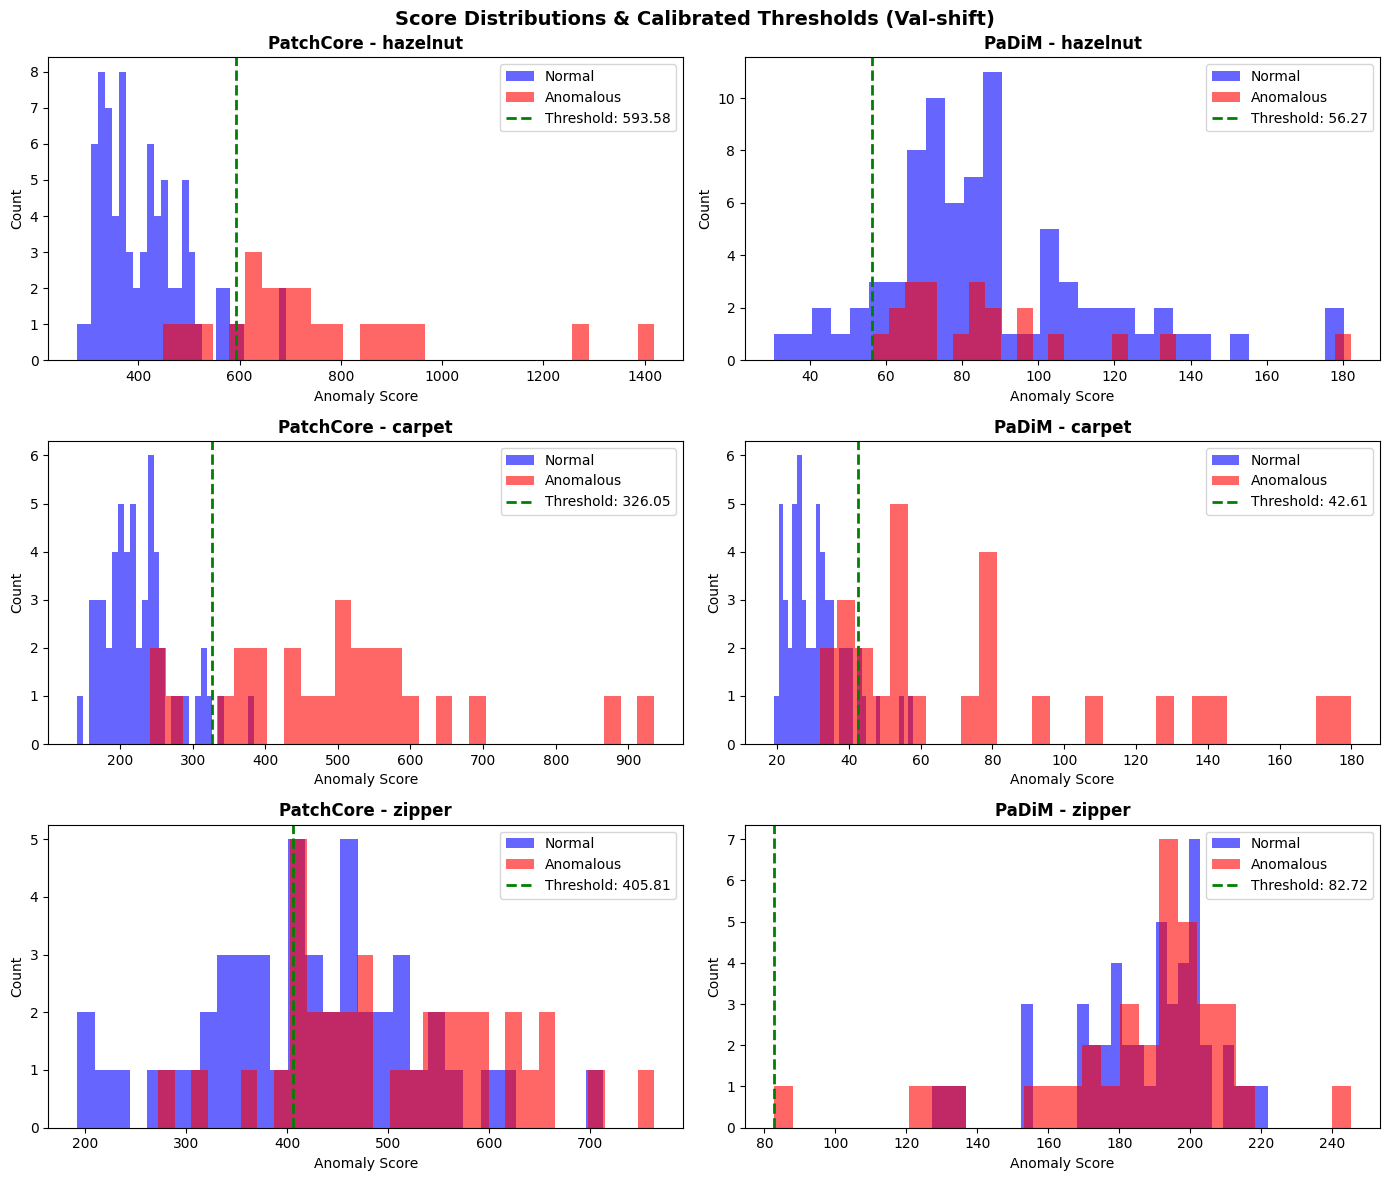

In [8]:
# Visualization: Score distributions and thresholds
fig, axes = plt.subplots(len(CLASSES), 2, figsize=(14, 4*len(CLASSES)))

for i, class_name in enumerate(CLASSES):
    # PatchCore
    ax1 = axes[i, 0]
    pc_data = calibration_data['patchcore'][class_name]
    normal_scores = pc_data['scores'][pc_data['labels'] == 0]
    anomalous_scores = pc_data['scores'][pc_data['labels'] == 1]

    ax1.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='blue')
    ax1.hist(anomalous_scores, bins=30, alpha=0.6, label='Anomalous', color='red')
    ax1.axvline(pc_data['threshold'], color='green', linestyle='--', linewidth=2,
                label=f'Threshold: {pc_data["threshold"]:.2f}')
    ax1.set_title(f'PatchCore - {class_name}', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Anomaly Score')
    ax1.set_ylabel('Count')
    ax1.legend()

    # PaDiM
    ax2 = axes[i, 1]
    pd_data = calibration_data['padim'][class_name]
    normal_scores = pd_data['scores'][pd_data['labels'] == 0]
    anomalous_scores = pd_data['scores'][pd_data['labels'] == 1]

    ax2.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='blue')
    ax2.hist(anomalous_scores, bins=30, alpha=0.6, label='Anomalous', color='red')
    ax2.axvline(pd_data['threshold'], color='green', linestyle='--', linewidth=2,
                label=f'Threshold: {pd_data["threshold"]:.2f}')
    ax2.set_title(f'PaDiM - {class_name}', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Anomaly Score')
    ax2.set_ylabel('Count')
    ax2.legend()

plt.suptitle('Score Distributions & Calibrated Thresholds (Val-shift)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'score_distributions_shift_threshold.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Evaluation on Test-Shift with Recalibrated Thresholds

Now we evaluate on the test set using the **recalibrated thresholds from Val-shift**.

In [9]:
# Load recalibrated thresholds from saved results
thresholds = {
    'patchcore': patchcore_calibrator.thresholds,
    'padim': padim_calibrator.thresholds
}

# Storage for results
all_results = {
    'patchcore': {},
    'padim': {}
}

### PatchCore: Evaluate on Test-shift

In [10]:
print("\n" + "="*60)
print("TEST-SHIFT EVALUATION (PATCHCORE)")
print("="*60)

for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # Create test dataset
    test_split = splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=0,
        collate_fn=custom_collate_fn
    )

    # Load model trained on CLEAN data
    model = PatchCore(
        backbone_layers=config.patchcore.layers,
        patch_size=config.patchcore.patch_size,
        coreset_ratio=config.patchcore.coreset_sampling_ratio,
        n_neighbors=config.patchcore.n_neighbors,
        device=DEVICE
    )
    model.load(PATCHCORE_MODELS_DIR, class_name, domain='clean')

    # Collect predictions
    all_scores = []
    all_labels = []
    all_heatmaps = []
    all_masks = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f'Testing {class_name}'):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images, return_heatmaps=True)

            all_scores.extend(scores.tolist())
            all_labels.extend(labels.numpy().tolist())

            for mask in masks:
                if mask is not None:
                    all_masks.append(mask.numpy().squeeze())
                else:
                    all_masks.append(None)

            all_heatmaps.extend([h for h in heatmaps])

    # Convert to arrays
    test_scores = np.array(all_scores)
    test_labels = np.array(all_labels)

    # Get recalibrated threshold
    threshold = thresholds['patchcore'][class_name]

    # Compute image-level metrics
    image_metrics = compute_image_metrics(test_labels, test_scores, threshold=threshold)

    # Compute pixel-level metrics
    pixel_metrics = compute_pixel_metrics(all_masks, all_heatmaps, compute_pro_metric=True)

    # Store results
    all_results['patchcore'][class_name] = {
        'threshold': threshold,
        'image_level': image_metrics,
        'pixel_level': pixel_metrics,
        'test_scores': test_scores.tolist(),
        'test_labels': test_labels.tolist()
    }

    # Print results
    print(f"  Threshold (recalibrated on val-shift): {threshold:.4f}")
    print(f"  AUROC: {image_metrics['auroc']:.4f}")
    print(f"  AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1: {image_metrics['f1']:.4f}")
    print(f"  Accuracy: {image_metrics.get('accuracy', 'N/A'):.4f}")
    print(f"  Pixel AUROC: {pixel_metrics.get('pixel_auroc', 'N/A')}")
    print(f"  PRO: {pixel_metrics.get('pro', 'N/A')}")


TEST-SHIFT EVALUATION (PATCHCORE)

--- HAZELNUT ---


Testing hazelnut:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold (recalibrated on val-shift): 593.5777
  AUROC: 0.9883
  AUPRC: 0.9915
  F1: 0.8605
  Accuracy: 0.8652
  Pixel AUROC: 0.9680288233667869
  PRO: 0.744806302840756

--- CARPET ---


Testing carpet:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold (recalibrated on val-shift): 326.0456
  AUROC: 0.9371
  AUPRC: 0.9726
  F1: 0.8696
  Accuracy: 0.8352
  Pixel AUROC: 0.9525565920151716
  PRO: 0.7192273348420473

--- ZIPPER ---


Testing zipper:   0%|          | 0/15 [00:00<?, ?it/s]

  Threshold (recalibrated on val-shift): 405.8055
  AUROC: 0.7504
  AUPRC: 0.8760
  F1: 0.8193
  Accuracy: 0.7414
  Pixel AUROC: 0.8456490186924561
  PRO: 0.4723334295035564


### PaDiM: Evaluate on Test-shift

In [11]:
print("\n" + "="*60)
print("TEST-SHIFT EVALUATION (PADIM)")
print("="*60)

for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # Create test dataset
    test_split = splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=0,
        collate_fn=custom_collate_fn
    )

    # Load model trained on CLEAN data
    model = PadimWrapper(
        backbone=config.padim.backbone,
        layers=config.padim.layers,
        n_features=config.padim.n_features,
        image_size=config.dataset.image_size,
        device=DEVICE
    )
    model.load(PADIM_MODELS_DIR / f'padim_{class_name}_clean.pt')

    # Collect predictions
    all_scores = []
    all_labels = []
    all_heatmaps = []
    all_masks = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f'Testing {class_name}'):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images, return_heatmaps=True)

            all_scores.extend(scores.tolist())
            all_labels.extend(labels.numpy().tolist())

            for mask in masks:
                if mask is not None:
                    all_masks.append(mask.numpy().squeeze())
                else:
                    all_masks.append(None)

            all_heatmaps.extend([h for h in heatmaps])

    # Convert to arrays
    test_scores = np.array(all_scores)
    test_labels = np.array(all_labels)

    # Get recalibrated threshold
    threshold = thresholds['padim'][class_name]

    # Compute image-level metrics
    image_metrics = compute_image_metrics(test_labels, test_scores, threshold=threshold)

    # Compute pixel-level metrics
    pixel_metrics = compute_pixel_metrics(all_masks, all_heatmaps, compute_pro_metric=True)

    # Store results
    all_results['padim'][class_name] = {
        'threshold': threshold,
        'image_level': image_metrics,
        'pixel_level': pixel_metrics,
        'test_scores': test_scores.tolist(),
        'test_labels': test_labels.tolist()
    }

    # Print results
    print(f"  Threshold (recalibrated on val-shift): {threshold:.4f}")
    print(f"  AUROC: {image_metrics['auroc']:.4f}")
    print(f"  AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1: {image_metrics['f1']:.4f}")
    print(f"  Accuracy: {image_metrics.get('accuracy', 'N/A'):.4f}")
    print(f"  Pixel AUROC: {pixel_metrics.get('pixel_auroc', 'N/A')}")
    print(f"  PRO: {pixel_metrics.get('pro', 'N/A')}")


TEST-SHIFT EVALUATION (PADIM)

--- HAZELNUT ---
[OK] Model loaded: padim_hazelnut_clean.pt


Testing hazelnut:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold (recalibrated on val-shift): 56.2653
  AUROC: 0.6046
  AUPRC: 0.6605
  F1: 0.7111
  Accuracy: 0.5618
  Pixel AUROC: 0.7989664317107451
  PRO: 0.5277679316037855

--- CARPET ---
[OK] Model loaded: padim_carpet_clean.pt


Testing carpet:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold (recalibrated on val-shift): 42.6108
  AUROC: 0.8940
  AUPRC: 0.9559
  F1: 0.8496
  Accuracy: 0.8132
  Pixel AUROC: 0.9546002303166947
  PRO: 0.737471198873605

--- ZIPPER ---
[OK] Model loaded: padim_zipper_clean.pt


Testing zipper:   0%|          | 0/15 [00:00<?, ?it/s]

  Threshold (recalibrated on val-shift): 82.7185
  AUROC: 0.5547
  AUPRC: 0.7837
  F1: 0.8400
  Accuracy: 0.7241
  Pixel AUROC: 0.7261884300640181
  PRO: 0.31604571649587515


## 6. Visualization

### Confusion Matrices

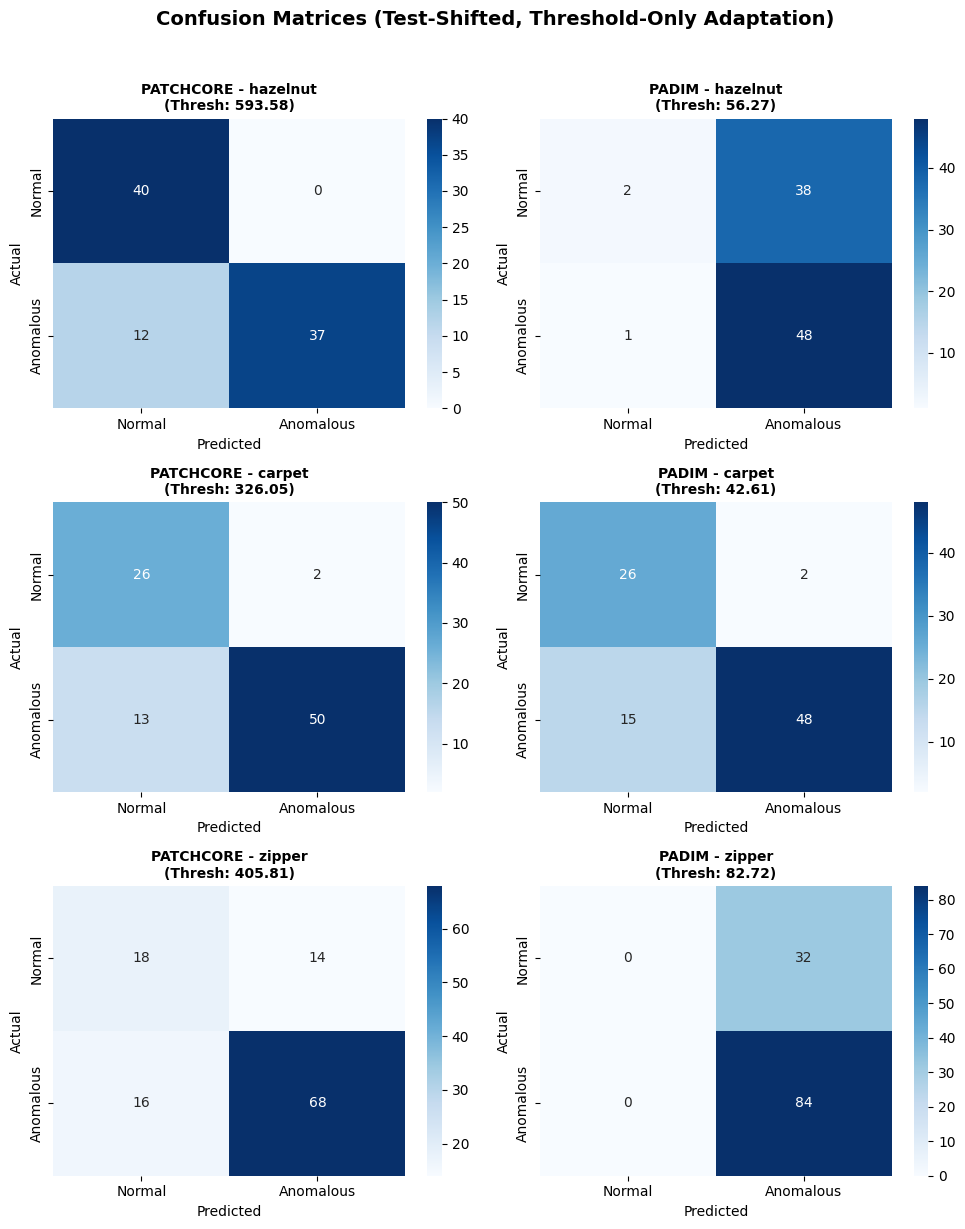

In [12]:
fig, axes = plt.subplots(len(CLASSES), 2, figsize=(10, 4*len(CLASSES)))

for i, class_name in enumerate(CLASSES):
    for j, method in enumerate(['patchcore', 'padim']):
        ax = axes[i, j]

        scores = np.array(all_results[method][class_name]['test_scores'])
        labels = np.array(all_results[method][class_name]['test_labels'])
        threshold = all_results[method][class_name]['threshold']

        cm = compute_confusion_matrix(labels, scores, threshold)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Normal', 'Anomalous'],
                    yticklabels=['Normal', 'Anomalous'])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'{method.upper()} - {class_name}\n(Thresh: {threshold:.2f})', fontsize=10, fontweight='bold')

plt.suptitle('Confusion Matrices (Test-Shifted, Threshold-Only Adaptation)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(VIZ_DIR / 'confusion_matrices_shifted_threshold_only.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Save Results & Copy to Drive

In [13]:
# Helper to convert results for JSON serialization
def convert_for_json(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_for_json(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_for_json(i) for i in obj]
    else:
        return obj

# Save full results JSON
json_path = RESULTS_DIR / 'shifted_threshold_only_results.json'
with open(json_path, 'w') as f:
    json.dump(convert_for_json(all_results), f, indent=2)
print(f"[OK] Results saved: {json_path.name}")

# Create summary CSV
import pandas as pd
summary_rows = []

for method, method_results in all_results.items():
    for class_name, res in method_results.items():
        row = {
            'Method': method.upper(),
            'Class': class_name,
            'Threshold': res['threshold'],
            'AUROC': res['image_level']['auroc'],
            'AUPRC': res['image_level']['auprc'],
            'F1': res['image_level']['f1'],
            'Accuracy': res['image_level']['accuracy'],
            'Pixel AUROC': res['pixel_level']['pixel_auroc'],
            'PRO': res['pixel_level']['pro']
        }
        summary_rows.append(row)

# Create DataFrame
df = pd.DataFrame(summary_rows)

# Add Macro Average
for method in ['PATCHCORE', 'PADIM']:
    method_df = df[df['Method'] == method]
    if not method_df.empty:
        macro_avg = method_df.mean(numeric_only=True)
        macro_row = macro_avg.to_dict()
        macro_row['Method'] = method
        macro_row['Class'] = 'Macro_average'
        summary_rows.append(macro_row)

final_df = pd.DataFrame(summary_rows)
csv_path = RESULTS_DIR / 'shifted_threshold_only_results_summary.csv'
final_df.to_csv(csv_path, index=False)
print(f"[OK] Summary saved: {csv_path.name}")

print("\n" + "="*60)
print("SUMMARY RESULTS (Threshold-Only Adaptation)")
print("="*60)
print(final_df[['Method', 'Class', 'AUROC', 'F1', 'Pixel AUROC', 'PRO']].to_string(index=False))

[OK] Results saved: shifted_threshold_only_results.json
[OK] Summary saved: shifted_threshold_only_results_summary.csv

SUMMARY RESULTS (Threshold-Only Adaptation)
   Method         Class    AUROC       F1  Pixel AUROC      PRO
PATCHCORE      hazelnut 0.988265 0.860465     0.968029 0.744806
PATCHCORE        carpet 0.937075 0.869565     0.952557 0.719227
PATCHCORE        zipper 0.750372 0.819277     0.845649 0.472333
    PADIM      hazelnut 0.604592 0.711111     0.798966 0.527768
    PADIM        carpet 0.893991 0.849558     0.954600 0.737471
    PADIM        zipper 0.554688 0.840000     0.726188 0.316046
PATCHCORE Macro_average 0.891904 0.849769     0.922078 0.645456
    PADIM Macro_average 0.684423 0.800223     0.826585 0.527095


## Files Generated

This notebook generates the following files for **Test-Shifted, No Adaptation Evaluation**:

`outputs/results/`
- `shift_threshold_only_results.json` — Complete evaluation results in JSON format with all metrics per model and class
- `shift_threshold_only_results_summary.csv` — Summary table with image-level and pixel-level metrics for all models/classes

`outputs/visualizations/shift_threshold_only/`
- `confusion_matrices_shift_threshold_only.png` — Confusion matrices at optimal threshold for all class/method combinations
- `score_distributions_shift_threshold_only.png` — Score distributions for all class/method combinations


## Save Results on Drive

In [15]:
# Create destination folders
THRESHOLD_ONLY_OUTPUTS = DRIVE_ROOT / '08_threshold_only_outputs'
THRESHOLD_ONLY_OUTPUTS.mkdir(parents=True, exist_ok=True)

import shutil

generated_files = [
    THRESHOLDS_DIR / 'shift_threshold_only_patchcore.json',
    THRESHOLDS_DIR / 'shift_threshold_only_padim.json',
    RESULTS_DIR / 'shifted_threshold_only_results.json',
    RESULTS_DIR / 'shifted_threshold_only_results_summary.csv',
    VIZ_DIR / 'score_distributions_shift_threshold.png',
    VIZ_DIR / 'confusion_matrices_shifted_threshold_only.png'
]

print("\nCopying files to Drive...")
for src in generated_files:
    if src.exists():
        dst = THRESHOLD_ONLY_OUTPUTS / src.name
        shutil.copy(src, dst)
        print(f"  [COPIED] {src.name}")
    else:
        print(f"  [MISSING] {src.name}")

print(f"\nAll results saved to: {THRESHOLD_ONLY_OUTPUTS}")


Copying files to Drive...
  [COPIED] shift_threshold_only_patchcore.json
  [COPIED] shift_threshold_only_padim.json
  [COPIED] shifted_threshold_only_results.json
  [COPIED] shifted_threshold_only_results_summary.csv
  [COPIED] score_distributions_shift_threshold.png
  [COPIED] confusion_matrices_shifted_threshold_only.png

All results saved to: /content/drive/MyDrive/anomaly_detection_project/08_threshold_only_outputs
